In [40]:
import os
import random
import time
import json

import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

#split
from sklearn.model_selection import train_test_split

In [41]:
dataset_path  = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

save_data_path = "./mmsegmentation/data/trash_dataset" #/img_dir, /ann_dir

In [42]:
#기존 폴더 삭제
for root, dirs, files in os.walk("./mmsegmentation/data/trash_dataset", topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

#폴더 새로 생성
for i in ["train","val"]:
    if not os.path.exists(save_data_path + "/img_dir/" + i + "/"):
        os.makedirs(save_data_path + "/img_dir/" + i)
    if not os.path.exists(save_data_path + "/ann_dir/" + i):
        os.makedirs(save_data_path + "/ann_dir/" + i)
    

In [43]:
category_names = ['Backgroud',
                'General trash',
                'Paper',
                'Paper pack',
                'Metal',
                'Glass',
                'Plastic',
                'Styrofoam',
                'Plastic bag',
                'Battery',
                'Clothing']

color = [["Backgroud",0,0,0],
        ["General trash",192,0,128],
        ["Paper",0,128,192],
        ["Paper pack",0,128,64],
        ["Metal",128,0,0],
        ["Glass",64,0,128],
        ["Plastic",64,0,192],
        ["Styrofoam",192,128,64],
        ["Plastic bag",192,192,128],
        ["Battery",64,64,128],
        ["Clothing",128,0,192]]
class_colormap = pd.DataFrame(color,columns=["name","r","g","b"])

In [44]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [45]:
coco = COCO(anns_file_path)
data = coco.getImgIds()

loading annotations into memory...
Done (t=4.92s)
creating index...
index created!


## split data

In [46]:
data_train, data_val, labels_train, labels_val \
    = train_test_split(data, data, test_size=0.20, random_state=42)

mode = {"train":data_train, "val":data_val}

  0%|          | 0/2617 [00:00<?, ?it/s]

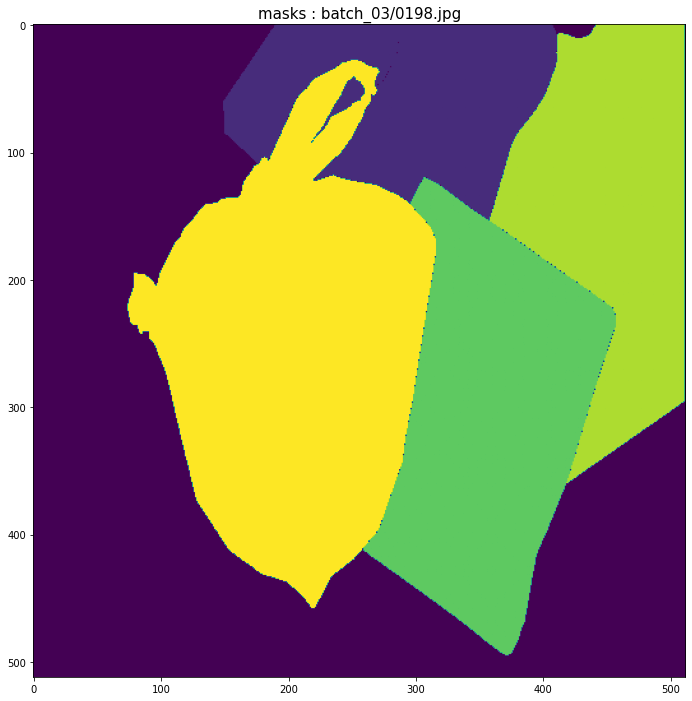

  0%|          | 1/2617 [00:00<10:47,  4.04it/s]

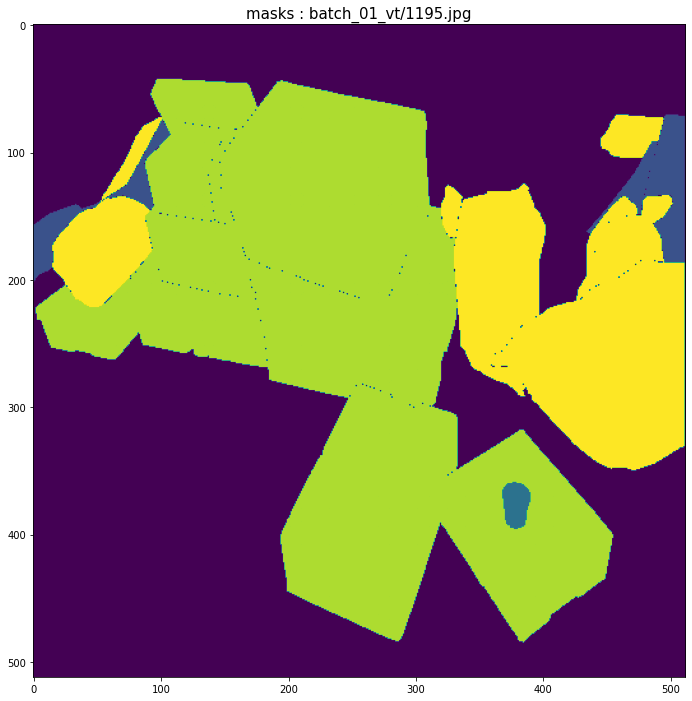

  0%|          | 2/2617 [00:00<10:46,  4.04it/s]

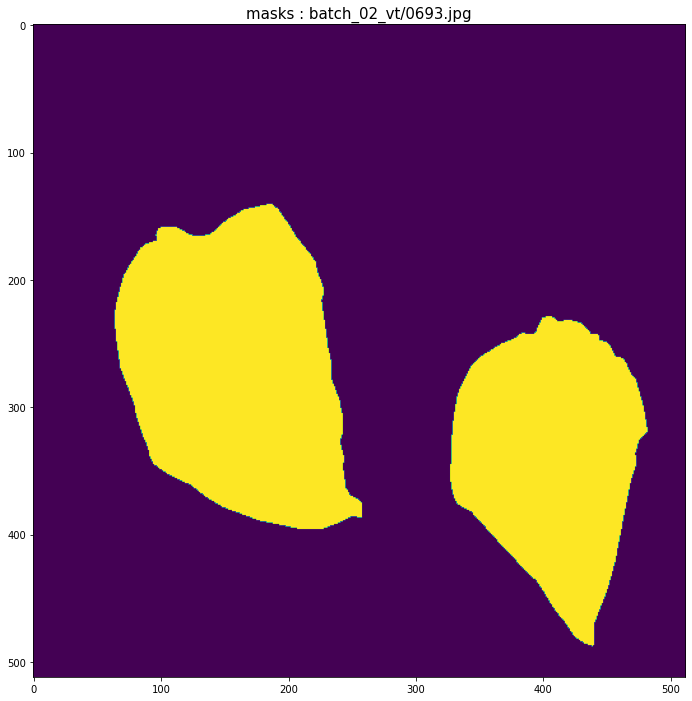

  0%|          | 3/2617 [00:00<10:32,  4.13it/s]

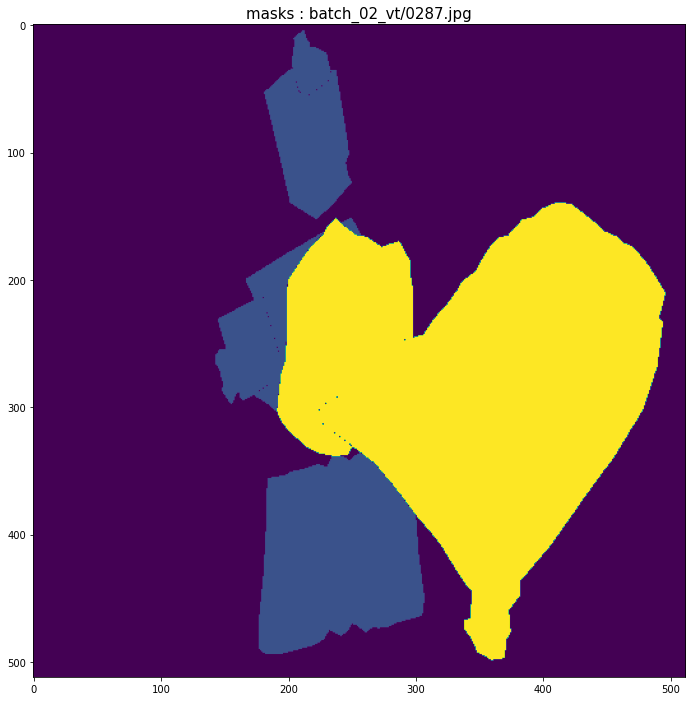

  0%|          | 4/2617 [00:00<10:29,  4.15it/s]

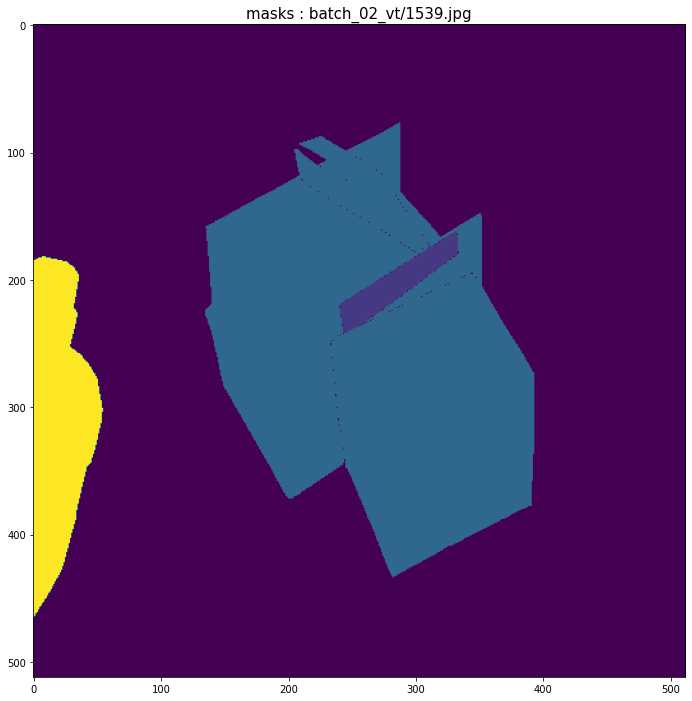

  0%|          | 5/2617 [00:01<10:25,  4.18it/s]

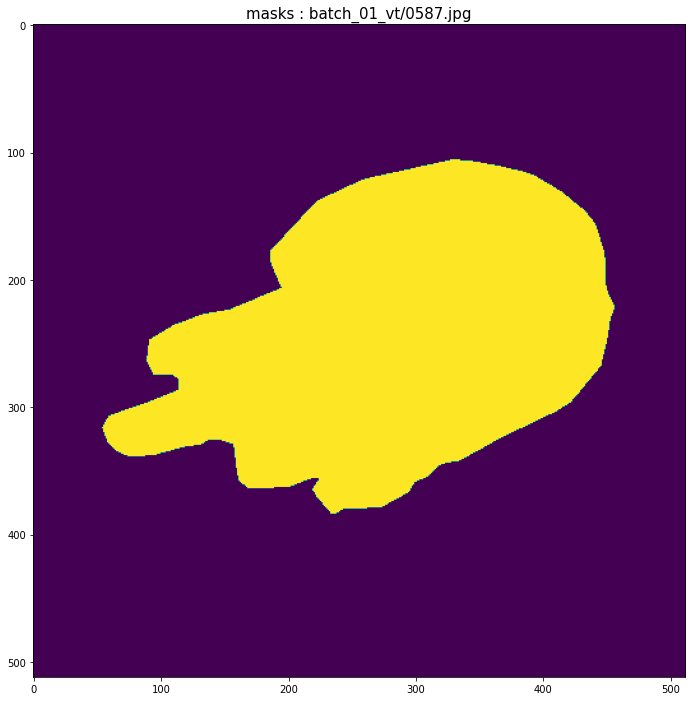

  0%|          | 6/2617 [00:01<10:16,  4.24it/s]

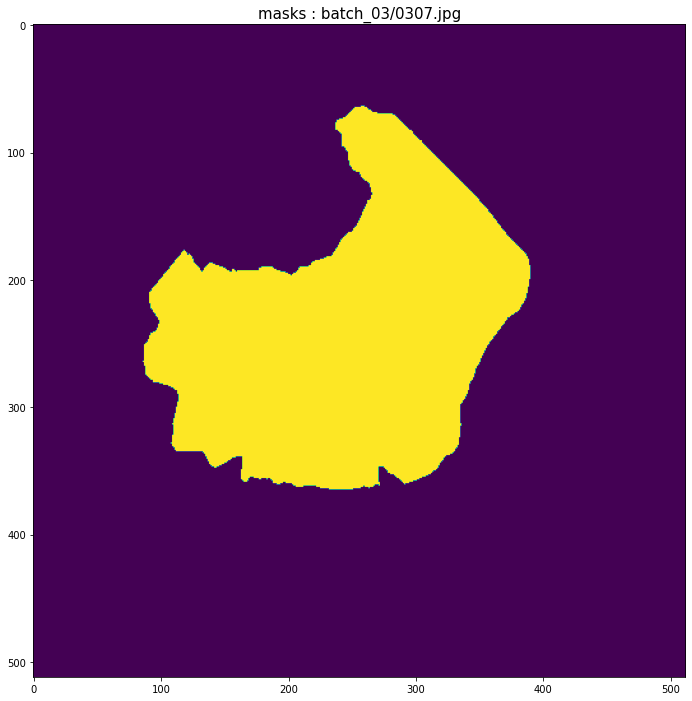

  0%|          | 7/2617 [00:01<10:10,  4.27it/s]

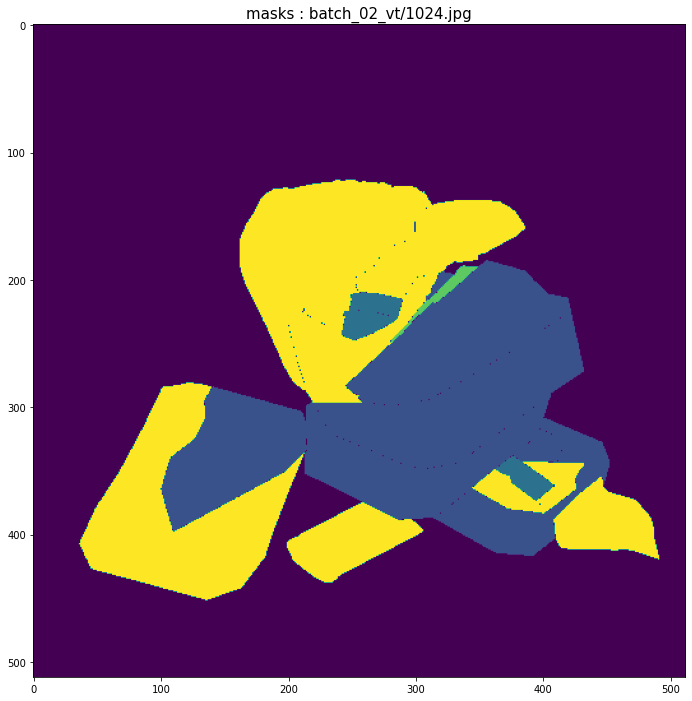

  0%|          | 8/2617 [00:01<10:15,  4.24it/s]

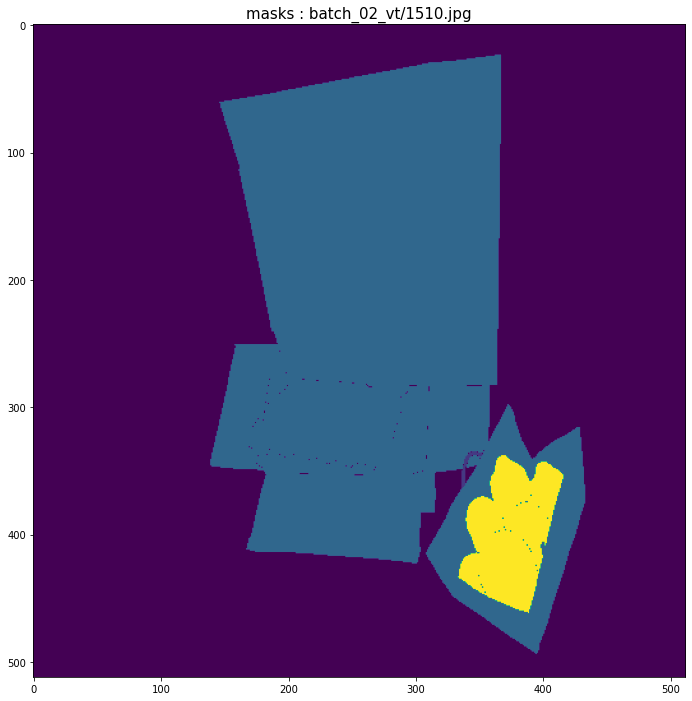

  0%|          | 9/2617 [00:02<10:14,  4.25it/s]

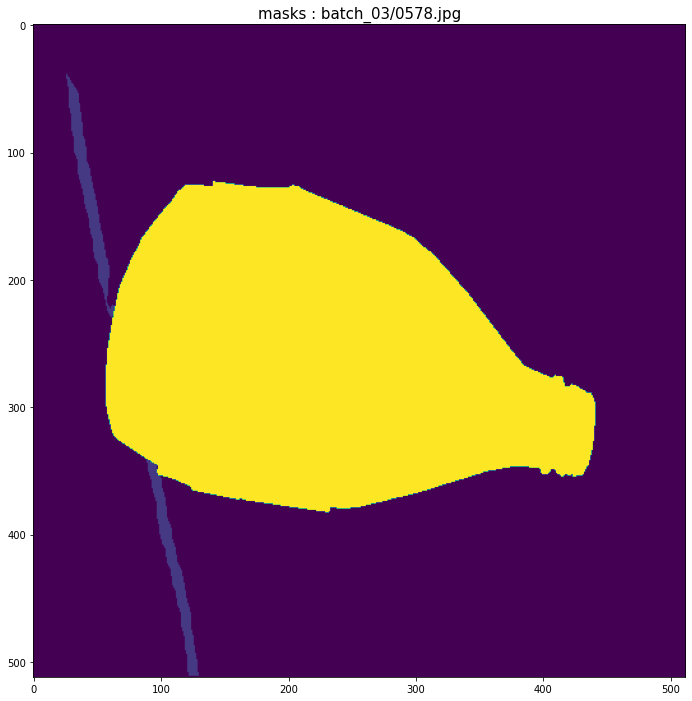

  0%|          | 10/2617 [00:02<10:10,  4.27it/s]

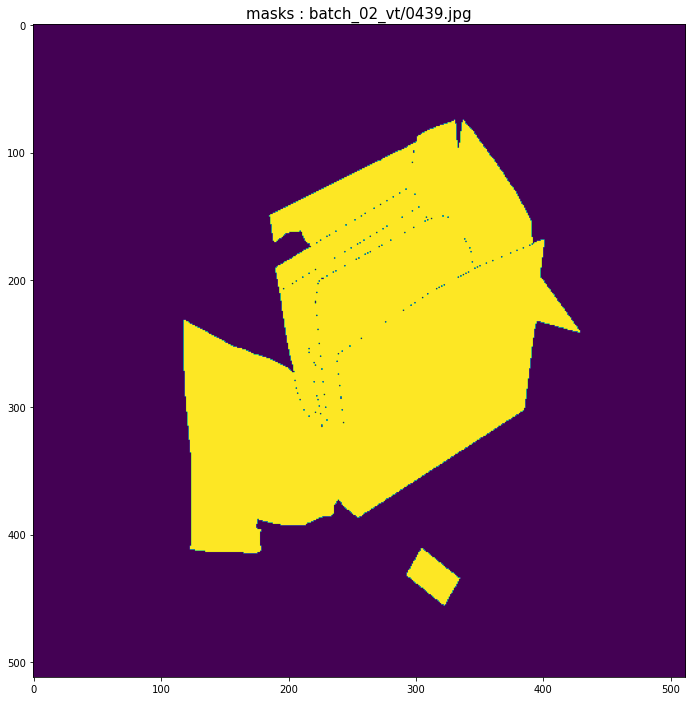

  0%|          | 11/2617 [00:02<10:10,  4.27it/s]

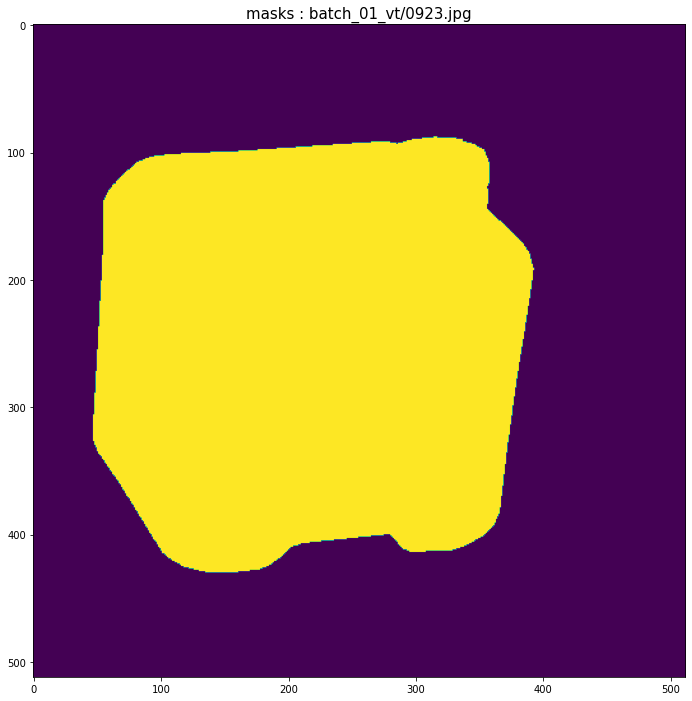

  0%|          | 12/2617 [00:02<10:02,  4.33it/s]

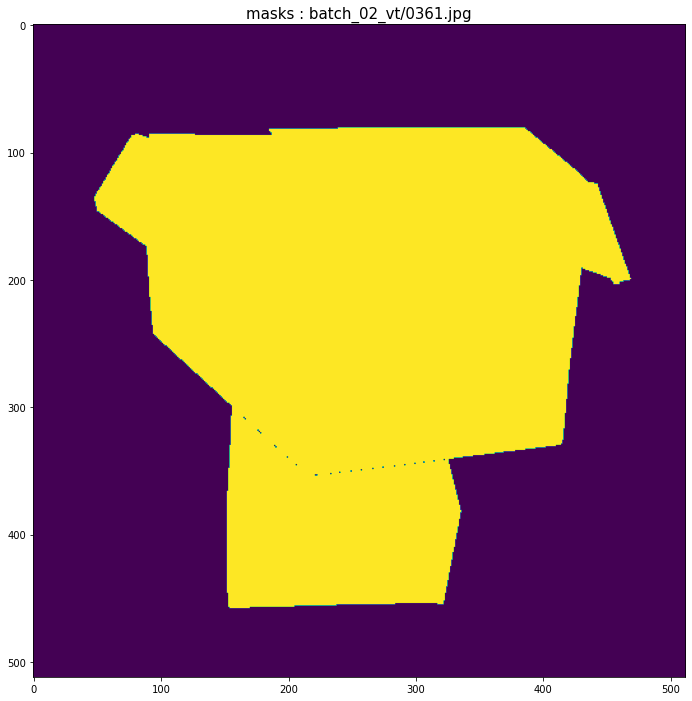

  0%|          | 13/2617 [00:03<09:57,  4.36it/s]

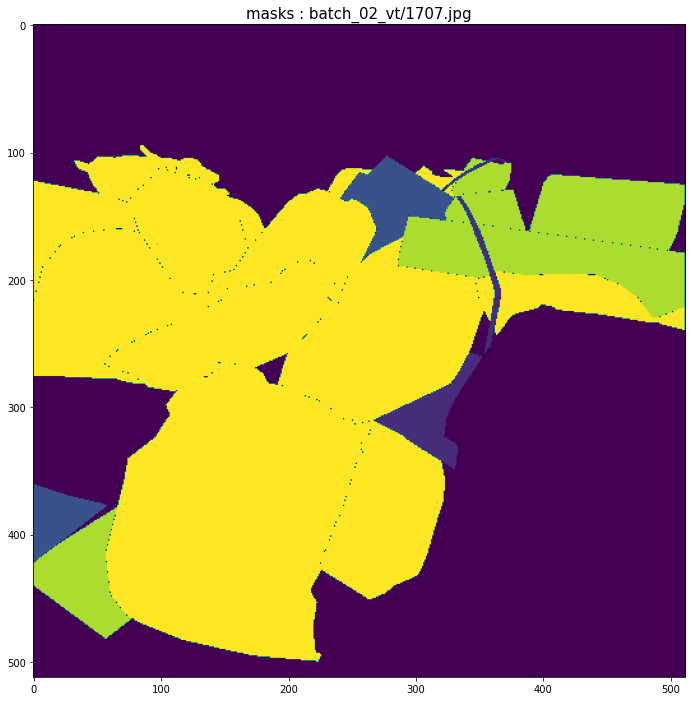

  1%|          | 14/2617 [00:03<10:10,  4.26it/s]

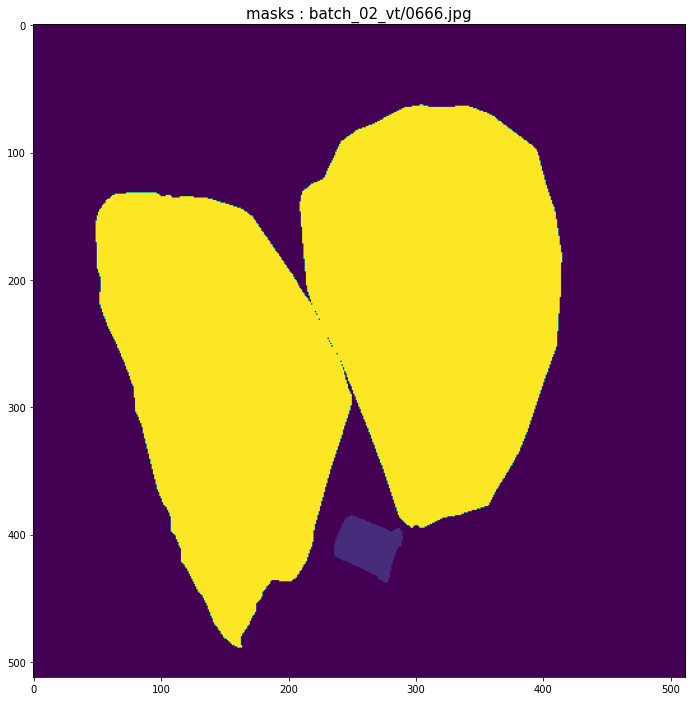

  1%|          | 15/2617 [00:03<10:09,  4.27it/s]

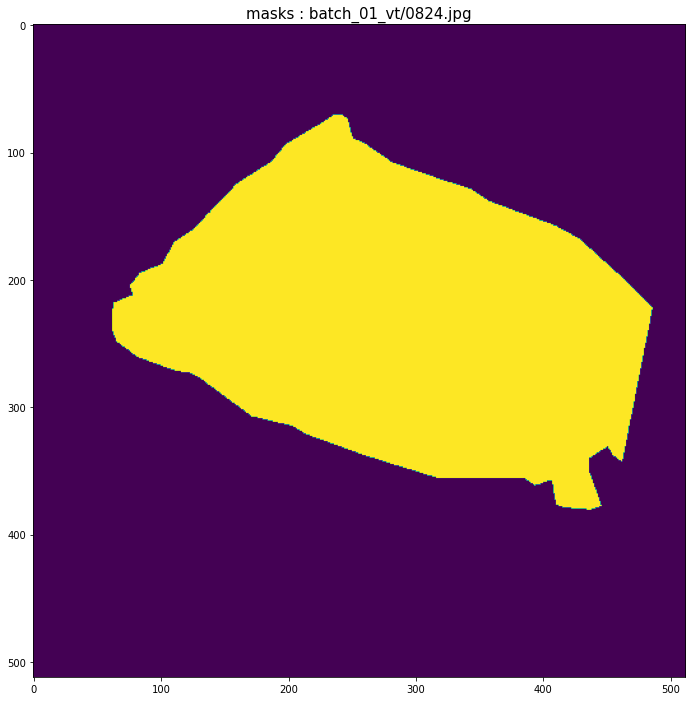

  1%|          | 16/2617 [00:03<10:05,  4.30it/s]

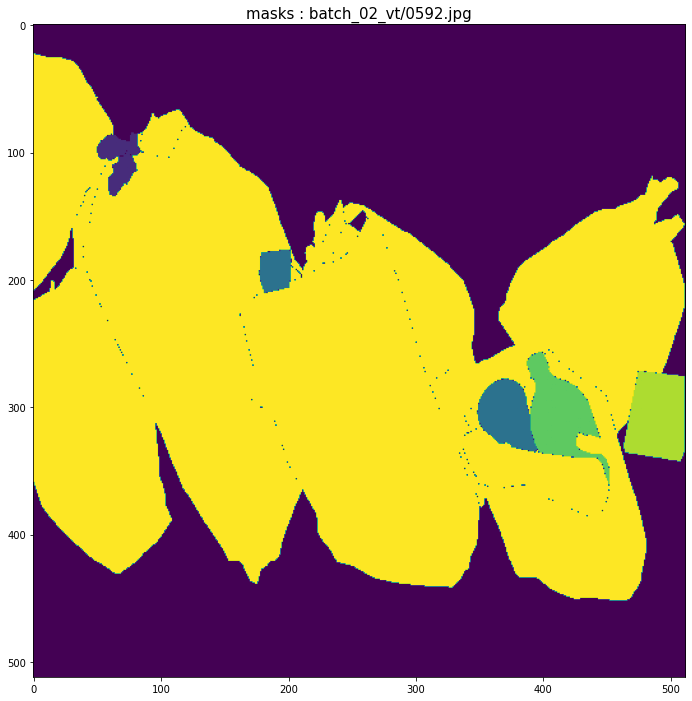

  1%|          | 17/2617 [00:04<10:17,  4.21it/s]

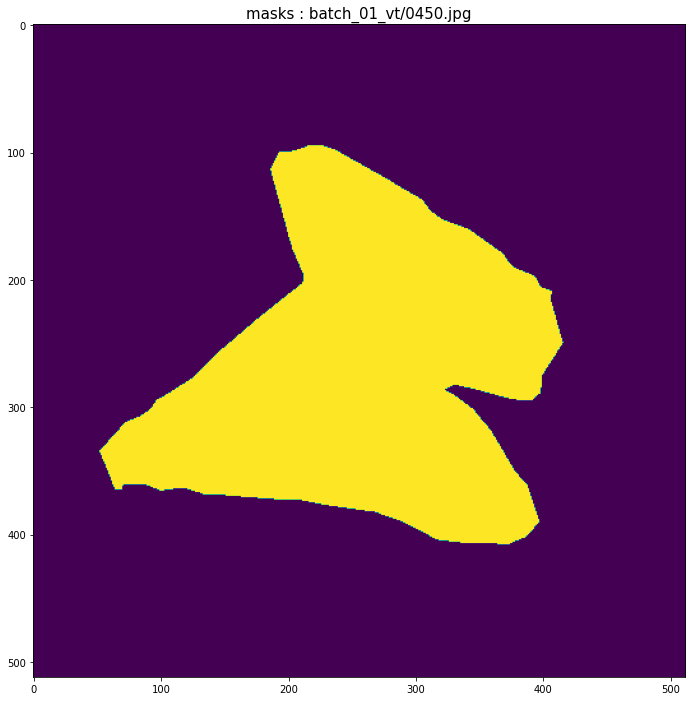

  1%|          | 18/2617 [00:04<10:12,  4.25it/s]

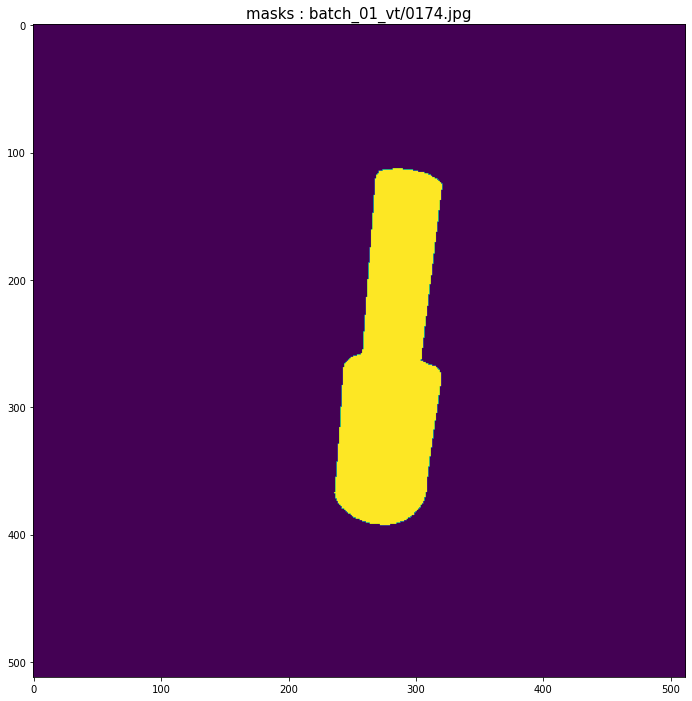

  1%|          | 18/2617 [00:04<10:42,  4.04it/s]


KeyboardInterrupt: 

In [47]:
for k, v in mode.items():
    for idx in tqdm(v):
        image_id = coco.getImgIds(imgIds=idx)
        image_infos = coco.loadImgs(image_id)[0]
        
        #파일 이름 정하기
        #image_infos['file_name'] 

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        # images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        # images /= 255.0
            
        ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
        anns = coco.loadAnns(ann_ids)

        # Load the categories in a variable
        cat_ids = coco.getCatIds()
        cats = coco.loadCats(cat_ids)
        
        # masks : size가 (height x width)인 2D
        # 각각의 pixel 값에는 "category id" 할당
        # Background = 0
        masks = np.zeros((image_infos["height"], image_infos["width"]))
        # General trash = 1, ... , Cigarette = 10
        anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
        for i in range(len(anns)):
            pixel_value = category_names.index(cats[anns[i]['category_id']-1]["name"])
            masks[coco.annToMask(anns[i]) == 1] = pixel_value
        masks = masks.astype(np.int8)
        
        #masks = label_to_color_image(masks)
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
        # ax.imshow(masks)
        # ax.grid(False)
        # ax.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)    
        # plt.show()

        
        cv2.imwrite(save_data_path + "/img_dir/" + k + "/" + image_infos['file_name'].split('/')[0] + "_" + image_infos['file_name'].split('/')[1][:-4] + ".png", images)
        cv2.imwrite(save_data_path + "/ann_dir/" + k + "/" + image_infos['file_name'].split('/')[0] + "_" + image_infos['file_name'].split('/')[1][:-4] + ".png", masks)
        